# ¿Por qué Tensorflow? 

*No es específicamente para redes neuronales, es más generalmente una arquitectura para ejecutar un gráfico de operaciones numéricas. Tensorflow puede optimizar el procesamiento de ese gráfico y distribuir su procesamiento a través de una red. Suena muy parecido a Apache spark, ¿eh? ¡También puede distribuir el trabajo a través de GPU! Puede manejar una escala masiva: fue hecho por Google. Funciona sobre cualquier cosa. Código C ++ eficiente con API de Python fáciles de usar*

*Un tensor es solo un nombre elegante para una matriz de valores. Para usar tensorflow, usted: Construya un gráfico para calcular su tensor. Inicialice las variables. Ejecute ese gráfico: nada sucede realmente hasta entonces*

In [1]:
import tensorflow as tf

a=tf.Variable(1,name='a')
b=tf.Variable(2,name='b')

f=a+b

tf.print(f)



3


**Creación de una red neuronal con tensorflow:**

*Ideas matemáticas: Todas esas flechas interconectadas que multiplican pesos pueden considerarse como una gran multiplicación de matrices. El término de sesgo se puede agregar al resultado de esa multiplicación de matrices. Entonces, en tensorflow, podemos definir una capa de una red neuronal como: output=tf.matmul(previous_layer, layer_weights)+layer_biases.  Al usar tensorflow directamente, estamos haciendo esto de la "manera difícil"*

*Cargue nuestros datos de entrenamiento y pruebas. Construir un gráfico que describa nuestra red neuronal. Asociar y optimizar con sus datos de entrenamiento. Evalúe su red entrenada con sus datos de prueba*

**Asegúrese de que sus características estén normalizadas.**

*Las redes neuronales generalmente funcionan mejor si los datos de entrada están normalizados. Es decir, 0 media y varianza unitaria. El objetivo real es que cada característica de entrada sea comparable en términos de magnitud. StandarScaler de Scikit_learn puede hacer esto por usted. Para empezar, muchas data_sets están normalizadas, como la que estamos a punto de usar.*

# Reconocimiento de escritura a mano

*El ejemplo estándar para el aprendizaje automático en estos días es el conjunto de datos MNIST, una colección de 70,000 muestras de escritura a mano de los números 0-9. Nuestro desafío: predecir qué número representa cada imagen manuscrita.*

*Aunque hablaremos de redes neuronales que son específicamente adecuadas para el reconocimiento de imágenes más adelante, en realidad no necesitamos ir allí para esta tarea relativamente simple. Podemos lograr resultados decentes sin una gran cantidad de código.*

*Cada imagen tiene píxeles de escala de grises de 28x28, por lo que podemos tratar cada imagen como una matriz 1D, o tensor, de 784 números. Mientras seamos consistentes en la forma en que aplanamos cada imagen en una matriz, seguirá funcionando. Sí, sería aún mejor si pudiéramos preservar la estructura 2D de los datos durante el entrenamiento, pero llegaremos allí más tarde.*

*Comencemos importando el conjunto de datos, que convenientemente es parte del propio tensorflow. Remodelaremos las imágenes en las matrices 1D de 784 píxeles que esperamos, y los datos de la etiqueta en un formato categórico codificado en caliente (que convertiremos durante nuestra definición de función de pérdida), de la que hablaremos en un segundo:*

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# MNIST dataset parameters
num_classes = 10 # total classes (0-9 digits)
num_features = 784 # data features (img shape: 28*28)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert to float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Flatten images to 1-D vector of 784 features (28*28)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalize images value from [0, 255] to [0, 1]
x_train, x_test = x_train / 255., x_test / 255.

11490434/11490434 [==============================] - 4s 0us/step


*MNIST proporciona 60,000 muestras en un conjunto de datos de entrenamiento y 10,000 muestras en un conjunto de datos de prueba. Si eres nuevo en el concepto de entrenamiento / prueba, es importante evaluar el rendimiento de nuestra red neuronal utilizando datos que nunca antes se habían visto. De lo contrario, es como darles a los estudiantes una prueba de matemáticas para problemas para los que ya tienen las respuestas. Por lo tanto, utilizamos un conjunto completamente diferente de imágenes para entrenar nuestra red neuronal de las imágenes utilizadas para probar su precisión.*

*Las imágenes de entrenamiento son, por lo tanto, un tensor de forma [60,000, 784] - 60,000 instancias de 784 números que representan cada imagen. Las etiquetas de entrenamiento son un tensor unidimensional de 60.000 etiquetas que van de 0 a 9.*

*Definamos una pequeña función que nos permita visualizar cómo se ven los datos de entrada, y elijamos alguna imagen de entrenamiento aleatoria para ver a qué nos enfrentamos:*

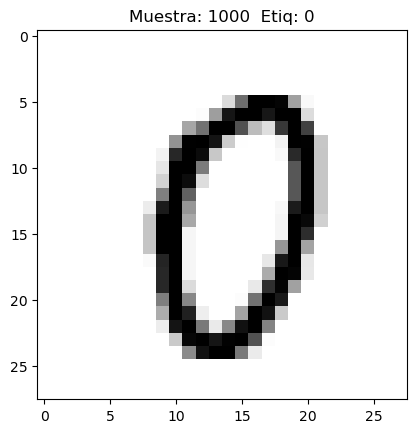

In [3]:

import matplotlib.pyplot as plt

def display_sample(num):
    #Print this sample's label 
    label = y_train[num] 
    
    #Reshape the 784 values to a 28x28 image
    image = x_train[num].reshape([28,28])
    plt.title('Muestra: %d  Etiq: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(1000)

*Por lo tanto, puede ver la etiqueta de entrenamiento para la imagen # 1000, así como cómo se ve esta muestra en particular. ¡Se puede decir que algunos de los datos de entrenamiento incluso serían difíciles de clasificar para un humano! Continúe y pruebe diferentes imágenes de entrada para tener una idea de los datos que se nos dan. Cualquier valor entre 0 y 60.000 funcionará.*

*Como recordatorio, estamos acoplando cada imagen a una matriz 1D de 784 (28 x 28) valores numéricos. Cada uno de esos valores será un nodo de entrada en nuestra red neuronal profunda. Visualicemos cómo se introducen los datos solo para llevar ese punto a casa:*

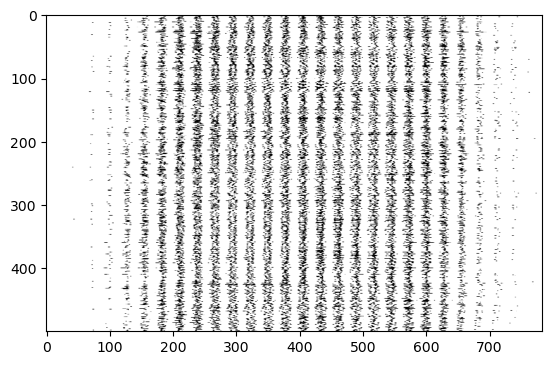

In [4]:
imagenes = x_train[0].reshape([1,784])
for i in range(1, 500):
    imagenes = np.concatenate((imagenes, x_train[i].reshape([1,784])))
plt.imshow(imagenes, cmap=plt.get_cmap('gray_r'))
plt.show()

*Esto muestra las primeras 500 muestras de entrenamiento, una en cada fila. Imagine que cada píxel en cada fila se alimenta en la capa inferior de una red neuronal de 768 neuronas (o "unidades") de ancho mientras entrenamos nuestra red neuronal.*

*Ahora definiremos pocos parámetros de entrenamiento (o "hiperparámetros") y usaremos tf.data API para barajar nuestros datos y dividirlos en lotes. Piense en esto como parámetros: construimos nuestro modelo de red neuronal sin conocimiento de los datos reales que se introducirán en él; Solo necesitamos construirlo de tal manera que nuestros datos encajen.*

*Usaremos un conjunto de datos dentro de Tensorflow para envolver nuestras características y etiquetas de capacitación, y usaremos funciones del conjunto de datos para barajarlo aleatoriamente y agruparlo en trozos más pequeños para cada iteración de entrenamiento.*

In [5]:
learning_rate = 0.001
training_steps = 3000
batch_size = 250
display_step = 100

# Network parameters.
n_hidden = 512 # Number of neurons.

In [6]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(60000).batch(batch_size).prefetch(1)

*Así que comencemos a configurar esa red neuronal artificial. Comenzaremos creando variables para almacenar y realizar un seguimiento de los pesos y sesgos de las diferentes capas.*

*Necesitaremos una capa de entrada con un nodo por píxel de entrada por imagen, o 784 nodos. Eso alimentará una capa oculta de algún tamaño arbitrario: elijamos 512, dado por n_hidden. Esa capa oculta generará 10 valores, dados por num_classes, correspondientes a las puntuaciones de cada clasificación que se introducirán en softmax.*

In [7]:
random_normal = tf.initializers.RandomNormal()

weights = {
    'h': tf.Variable(random_normal([num_features, n_hidden])),
    'out': tf.Variable(random_normal([n_hidden, num_classes]))
}
biases = {
    'b': tf.Variable(tf.zeros([n_hidden])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

C:\Users\Dell Inspiron\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


*Ahora vamos a configurar la red neuronal en sí. Alimentaremos nuestros datos de entrada en la primera capa de nuestra red neuronal. Todo lo que hace esta capa es multiplicar estas entradas por nuestro tensor de peso "h" que se aprenderá con el tiempo.*

*Luego lo introduciremos en nuestra capa oculta, que aplica la función de activación sigmoide a las entradas ponderadas con nuestros sesgos aprendidos agregados también.*

In [8]:
def neural_net(inputData):
    # Hidden fully connected layer with 512 neurons.
    hidden_layer = tf.add(tf.matmul(inputData, weights['h']), biases['b'])
    # Apply sigmoid to hidden_layer output for non-linearity.
    hidden_layer = tf.nn.sigmoid(hidden_layer)
    
    # Output fully connected layer with a neuron for each class.
    out_layer = tf.matmul(hidden_layer, weights['out']) + biases['out']
    # Apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(out_layer)

*Asegúrese de fideos en el bloque anterior. Esto configura una red neuronal profunda como la que hablamos en nuestras diapositivas.*

*output layer*

*hidden layer*

*input layer*

*A continuación definiremos nuestra función de pérdida para su uso en la medición de nuestro progreso en el descenso de gradiente: la entropía cruzada, que aplica una escala logarítmica para penalizar las clasificaciones incorrectas mucho más que las que están cerca. En esta función, y_pred es la salida de nuestra capa final, y la estamos comparando con las etiquetas de destino utilizadas para el entrenamiento en y_true.*

*Para comparar nuestras conocidas etiquetas "verdaderas" de 0-9 con la salida de nuestra red neuronal, necesitamos convertir las etiquetas a codificación "de un solo calor". Nuestra capa de salida tiene una neurona para cada etiqueta posible de 0-9, no una sola neurona con un número entero en ella. Por ejemplo, digamos que una etiqueta "verdadera" conocida para una imagen es 1. Lo representaríamos en formato de un solo canal como [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] (recuerde que comenzamos a contar en 0). Esto hace que sea más fácil comparar la etiqueta conocida con las neuronas de salida.*

In [9]:
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

*Ahora configuraremos nuestro optimizador de descenso de gradiente estocástico, basado en nuestros hiperparámetros previamente definidos y nuestra función de pérdida definida anteriormente. Esa tasa de aprendizaje es un ejemplo de un hiperparámetro con el que puede valer la pena experimentar y ajustar.*

In [10]:
optimizer = tf.keras.optimizers.SGD(learning_rate)

def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = neural_net(x)
        loss = cross_entropy(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

*A continuación, querremos entrenar nuestra red neuronal y medir su precisión. Primero definamos algunos métodos para medir la precisión de nuestro modelo entrenado.*

*correct_prediction mirará la salida de nuestra red neuronal (en digit_weights) y elegirá la etiqueta con el valor más alto, y verá si eso concuerda con la etiqueta de destino dada. Durante las pruebas, digit_weights será nuestra predicción basada en los datos de prueba que le damos a la red, y target_labels es un marcador de posición que asignaremos a nuestras etiquetas de prueba. En última instancia, esto nos da un 1 para cada clasificación correcta y un 0 para cada clasificación incorrecta*

*"accuracy" luego toma el promedio de todas las clasificaciones para producir una puntuación general para la precisión de nuestro modelo.*

In [11]:
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

*¡Entrenemos esto y veamos cómo funciona!* 

*Tensorflow 2 eliminó la necesidad de configurar un objeto de sesión e inicializar explícitamente sus variables. Por lo tanto, podemos saltar directamente al entrenamiento de nuestra red en 3000 pasos (o "épocas", dadas por training_steps) con lotes de 250 muestras configuradas anteriormente en nuestros datos de entrenamiento. En cada paso, asignamos ejecutar nuestra función de optimización en el lote actual de imágenes y etiquetas de los datos de entrenamiento.*

*En cada 100 épochs (dadas por display_step), imprimimos los valores actuales de la función de pérdida y nuestra métrica de precisión, comparando nuestras etiquetas predichas con las etiquetas "verdaderas" conocidas. Para hacer esto, ejecutamos nuestra red neuronal utilizando nuestros pesos y sesgos entrenados en cada punto del lote actual de imágenes de entrenamiento, y calculamos la entropía cruzada y la precisión de las predicciones resultantes ("pred") a las etiquetas correctas conocidas ("batch_y").*

In [12]:
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("Training epoch: %i, Loss: %f, Accuracy: %f" % (step, loss, acc))

Training epoch: 100, Loss: 163.521790, Accuracy: 0.816000
Training epoch: 200, Loss: 126.346687, Accuracy: 0.892000
Training epoch: 300, Loss: 97.189743, Accuracy: 0.888000
Training epoch: 400, Loss: 109.402206, Accuracy: 0.896000
Training epoch: 500, Loss: 79.939667, Accuracy: 0.916000
Training epoch: 600, Loss: 107.964508, Accuracy: 0.880000
Training epoch: 700, Loss: 67.826706, Accuracy: 0.924000
Training epoch: 800, Loss: 69.152969, Accuracy: 0.912000
Training epoch: 900, Loss: 67.871750, Accuracy: 0.916000
Training epoch: 1000, Loss: 69.138550, Accuracy: 0.920000
Training epoch: 1100, Loss: 60.968033, Accuracy: 0.932000
Training epoch: 1200, Loss: 79.748146, Accuracy: 0.888000
Training epoch: 1300, Loss: 100.059235, Accuracy: 0.924000
Training epoch: 1400, Loss: 78.271454, Accuracy: 0.892000
Training epoch: 1500, Loss: 67.429214, Accuracy: 0.924000
Training epoch: 1600, Loss: 77.111343, Accuracy: 0.900000
Training epoch: 1700, Loss: 76.796776, Accuracy: 0.924000
Training epoch: 18

In [13]:
pred = neural_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.929900


*Debe tener una precisión de aproximadamente el 93%. ¡Bien! Pero bueno, apenas estamos empezando.*

*Echemos un vistazo a algunas de las imágenes mal clasificadas y veamos qué tan bueno o malo es nuestro modelo, en comparación con lo que su propio cerebro puede hacer. Repasaremos las primeras 200 imágenes de prueba y veremos las que están mal clasificadas:*

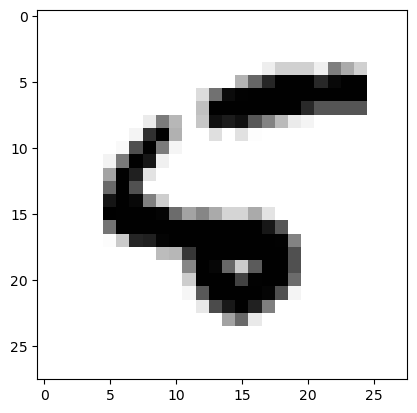

Etiq Original: 5
Modelo prediccion: 6


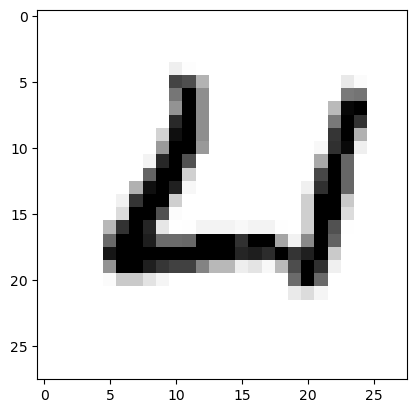

Etiq Original: 4
Modelo prediccion: 6


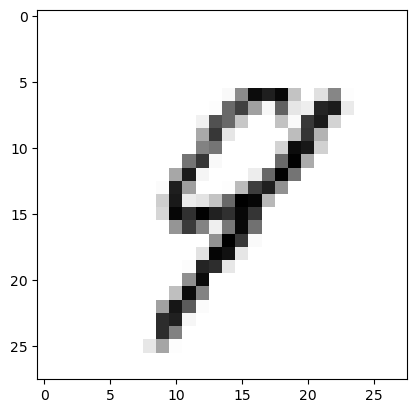

Etiq Original: 9
Modelo prediccion: 4


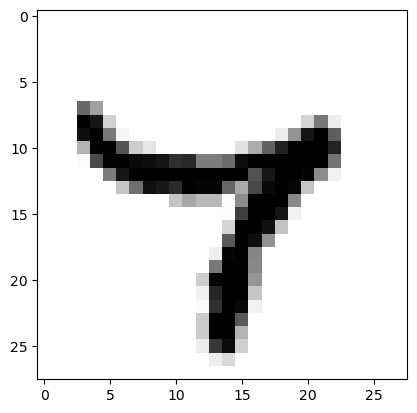

Etiq Original: 7
Modelo prediccion: 4


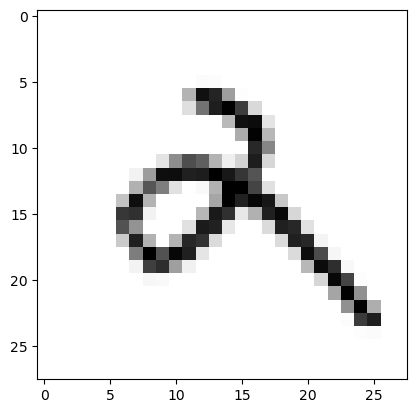

Etiq Original: 2
Modelo prediccion: 9


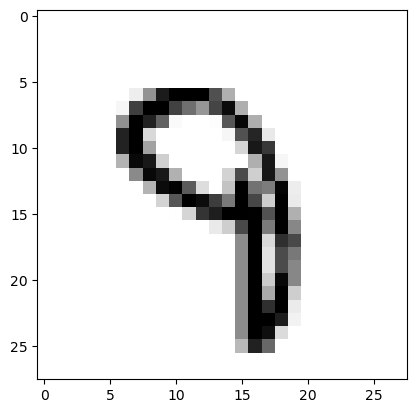

Etiq Original: 9
Modelo prediccion: 3


In [15]:
n_images = 200
test_images = x_test[:n_images]
test_labels = y_test[:n_images]
predictions = neural_net(test_images)

for i in range(n_images):
    model_prediction = np.argmax(predictions.numpy()[i])
    if (model_prediction != test_labels[i]):
        plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray_r')
        plt.show()
        print("Etiq Original: %i" % test_labels[i])
        print("Modelo prediccion: %i" % model_prediction)